# Figure 2

In [18]:
## Basics
import numpy as np
import pandas as pd
import glob
import mdtraj as md
import gzip

## Bio functions
from Bio.Seq import Seq
from Bio import SeqIO
from Bio import AlignIO
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord

## Plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Arial"

## Colors
cscheme = {'pos':'#0177BB', 'neg':'#CB3627', 'dis':'#828282', 'helix':'#009988', 'sheet':'#EE7733', 'cr':'#AA4499',
          'null':"black"}

In [3]:
import sys
sys.path.append("../code/scripts")
import parseaf as paf

In [4]:
# Filepaths
path_to_af_data = "/Volumes/DATA/alphafold/UP000002311_559292_YEAST/"

### Local functions

In [5]:
def get_ss_freqs(seq, counts = False, sort_output = True, gaps = False):
    ss_types = ['C', 'E', 'H']
    
    all_seq_ss = []
    all_seq_freqs = []
    
    # Parse sequence
    seq = list(seq)
    seq_ss, seq_counts = np.unique(seq, return_counts=True)
    zero_freq_ss = np.setxor1d(ss_types, seq_ss)

    seq_ss = np.append(seq_ss, zero_freq_ss)
    seq_freqs = np.append(seq_counts, np.zeros(zero_freq_ss.size))
    if not counts:
        seq_freqs = seq_freqs / len(seq)

    if sort_output:
        seq_freqs_sorted = seq_freqs[seq_ss.argsort()]
        all_seq_freqs.append(seq_freqs_sorted)

    else:
        all_seq_ss.append(seq_ss)
        all_seq_freqs.append(seq_freqs)
    
    if sort_output:
        return(all_seq_freqs)
    else:
        return(all_seq_ss, all_seq_freqs)

### Data

In [6]:
df = pd.read_csv('../data/charged_regions/cr_raw.csv',
                comment="#")

In [8]:
# Calculate normalized hydropathy, net charge, and percent disordered for each sequence
hits_disordered_frac = []
hits_conf = []
hits_ss = []

for index, row in df.iterrows():
    orf = row['orf']
    uid = row['uni_id']
    seq = row['region.seq']
    
    # Read alphafold pLDDT scoress for the sequence
    af_fp = paf.get_alphafold_fp(uid, path_to_af_data)+'.gz'
    try:
        pLDDTs = paf.read_bfactor_from_pdb(af_fp)[row['left.bound']:row['right.bound']+1]
    except FileNotFoundError:
        print(af_fp)
        continue
    
    
    #disordered = np.sum([1 for i in pLDDTs if i < 70.])
    
    # Get confidence scores mask
    conf = [True if i > 70. else False for i in pLDDTs]
    
    # Secondary structure prediction for each region
    structure = md.load(af_fp)
    ss = md.compute_dssp(structure, simplified=True)
    region_ss = ss[0][row['left.bound']:row['right.bound']+1]
    hits_ss.append(region_ss)
    
    # Score each residue as disordered or ordered based on pLDDT value
    ### UPDATE
    disordered = 0
    for r, resid in enumerate(pLDDTs):
        if resid < 70.:
            disordered += 1
        elif region_ss[r] == 'C':
            disordered += 1
        
    # Calculate fraction disorder for the region
    hits_disordered_frac.append(disordered / row['region.len'])
    hits_conf.append(conf)

/Users/triandafillou/opt/anaconda3/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-P53288-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-P38811-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-P38811-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-P36022-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-Q12019-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-Q12019-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-Q12019-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-Q12019-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-Q6B0X1-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-Q08428-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-Q12444-F1-model_v1.pdb.gz


In [12]:
# Compare to random regions of the same length
all_af_predictions = glob.glob(path_to_af_data+'*.pdb.gz')

rand_disordered_frac = []
rand_conf = []
rand_ss = []


for index, row in df.iterrows():
    # Choose random alphafold output
    rfile = np.random.choice(all_af_predictions)
    raf = paf.read_bfactor_from_pdb(rfile)
    # If the length of the protein is less than the region, redraw
    while row['region.len'] > len(raf):
        rfile = np.random.choice(all_af_predictions)
        raf = paf.read_bfactor_from_pdb(rfile)
    
    rstart = np.random.choice(np.arange(len(raf) - row['region.len']+1))
    rend = rstart+row['region.len']+1
    
    # Get the sequence of this random region
    rseq = paf.read_seq_from_pdb(rfile)[rstart:rend]
    if len(rseq) == 0:
        continue
    rpLDDTs = raf[rstart:rend]
    
    
    # Score each residue as disordered or ordered based on pLDDT value
    #disordered = np.sum([1 for i in rpLDDTs if i < 70.])
    conf = [True if i > 70. else False for i in rpLDDTs]
    

    
    # Secondary structure prediction for each region
    structure = md.load(rfile)
    ss = md.compute_dssp(structure, simplified=True)
    region_ss = ss[0][rstart:rend]
    rand_ss.append(region_ss)
    
    # Score each residue as disordered or ordered based on pLDDT value
    ### UPDATE
    disordered = 0
    for r, resid in enumerate(rpLDDTs):
        if resid < 70.:
            disordered += 1
        elif region_ss[r] == 'C':
            disordered += 1
            
    # Calculate fraction disorder for the region
    rand_disordered_frac.append(disordered / row['region.len'])
    rand_conf.append(conf)

/Users/triandafillou/opt/anaconda3/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


In [13]:
# Compare to regions from disprot:
yeast_disprot = pd.read_csv("../data/misc/search_in_disprot.tsv", sep = "\t")
uniprot_to_sgid = pd.read_table("../data/misc/uniprot-acc_to_sgid.txt", sep = "\t")
sgid_to_orf_names = ["SGID", "orf", "gene", "gene_name", "sgd_alias", "brief_description", "organism", "gene_type"]
sgid_to_orf = pd.read_csv("../data/misc/all-sgd-orfs-w-sgid-and-systematic.tsv", sep = "\t", names=sgid_to_orf_names)

In [15]:
mapping = pd.merge(uniprot_to_sgid, sgid_to_orf, how="left", on="SGID")
mapping = mapping.drop(["gene_name", "sgd_alias", "brief_description", "organism", "gene_type"], axis=1)
yeast_disprot_w_orfs = pd.merge(yeast_disprot, mapping, how='left', on=["acc"])
#yeast_disprot_w_orfs.head()

In [16]:
idr_disordered_frac = []
idr_conf = []
idr_ss = []


for index, row in yeast_disprot_w_orfs.iterrows():
    orf = row['orf']
    uid = row['acc']
    seq = row['region_sequence']
    start = row['start']
    end = row['end']

    # Pull the alphafold prediction for this region
    af_fp = paf.get_alphafold_fp(uid, path_to_af_data)+'.gz'
    try:
        pLDDTs = paf.read_bfactor_from_pdb(af_fp)[start:end]
    except FileNotFoundError:
        print("File {} not found".format(af_fp))
        continue
        
    # Check that region matches af prediction
    af_seq = paf.read_seq_from_pdb(af_fp)[start-1:end]
    if af_seq != seq:
        print("Sequences don't match for Uniprot ID {} (orf {})".format(uid,orf))
        continue

    # Binarize confidence scores
    conf = [True if i > 70. else False for i in pLDDTs]
    
    # Secondary structure prediction for each region
    structure = md.load(af_fp)
    ss = md.compute_dssp(structure, simplified=True)
    region_ss = ss[0][start:end]
    idr_ss.append(region_ss)
    
    # Score each residue as disordered or ordered based on pLDDT value
    ### UPDATE
    disordered = 0
    for r, resid in enumerate(pLDDTs):
        if resid < 70.:
            disordered += 1
        elif region_ss[r] == 'C':
            disordered += 1
    
    # Calculate fraction disorder for the region
    idr_disordered_frac.append(disordered / len(seq))
    idr_conf.append(conf)

/Users/triandafillou/opt/anaconda3/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


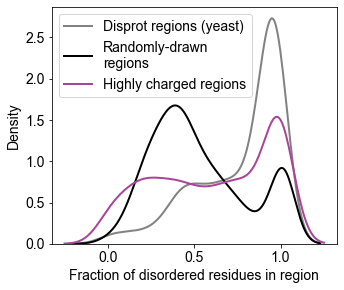

In [19]:
plt.figure(figsize=(5,4.25))
sns.kdeplot(idr_disordered_frac, label='Disprot regions (yeast)', color=cscheme['dis'], linewidth=2)
sns.kdeplot(rand_disordered_frac, label='Randomly-drawn\nregions', color=cscheme['null'], linewidth=2)
sns.kdeplot(hits_disordered_frac, label='Highly charged regions', color=cscheme['cr'], linewidth=2)
plt.xlabel('Fraction of disordered residues in region')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()